<a href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/challenges/challenge-one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 1: The banknote-authentication data set problem

We will perform a nearly realistic analysis of the data set bank note authentication that can be downloaded from https://archive.ics.uci.edu/dataset/267/banknote+authentication

## Data set description

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.
These features are:
1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous) 
3. curtosis of Wavelet Transformed image (continuous) 
4. entropy of image (continuous) 
5. class (integer)

## Task description
We have a binary classification problem. The assignment can be divided in several parts:
    
    1. Load the data and pretreatment.
    2. Data exploring by Unsupervised Learning techniques.
    3. Construction of several models of Supervised Learning.

### 1. Data pretreatment

Load the data and look at it: It is needed some kind of scaling? Why? Are the data points sorted in the original data set? Can it generate problems? How can this be solved?

In [20]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import os

In [21]:
# Load the dataset using Pandas
# We know a priori the features name so we use them
# We are lucky because our Category is already a numeric value so no transformation are needed
data = pd.read_csv('data_banknote_authentication.txt', header = None, names = ['Variance', 'Skewness', 'Curtosis', 'Entropy', 'Category'])
df = pd.DataFrame(data)
df.head()

,Variance,Skewness,Curtosis,Entropy,Category
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


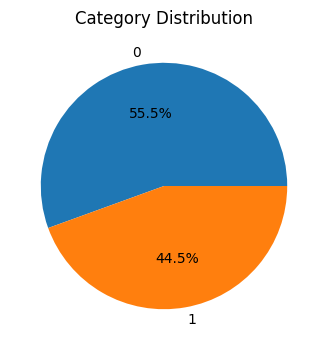

In [22]:
# Visualize the category distribution with a pie chart
category_counts = df['Category'].value_counts()
category_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(4, 4))
plt.title('Category Distribution', fontsize=12)
plt.ylabel('')
plt.show()

In [23]:
# Having pretty good balanced data is good.
# Shuffling the dataset is needed since it is ordered by category.
df = df.sample(frac=1).reset_index(drop=True)

In [24]:
from scipy.stats import shapiro

# Test the gaussianity of the columns just for ourself.

for col in df.columns: 
    if col != 'Category':
        p, stat = shapiro(df[col])
        print(f"{col}:")
        if p > 0.05:
            print(f"  Data seems to follow gaussian distribution [p-value {p}].")
        else:
            print(f"  Data does not seem to follow gaussian distribution [p-value {p}].")

# Standardize
for col in df.columns: 
    if col != 'Category':
        df[col] = (df[col] - df[col].mean()) / df[col].std()

Variance:
  Data seems to follow gaussian distribution [p-value 0.9819974938117775].
Skewness:
  Data seems to follow gaussian distribution [p-value 0.9746343038389308].
Curtosis:
  Data seems to follow gaussian distribution [p-value 0.927092532564124].
Entropy:
  Data seems to follow gaussian distribution [p-value 0.9148761718506763].


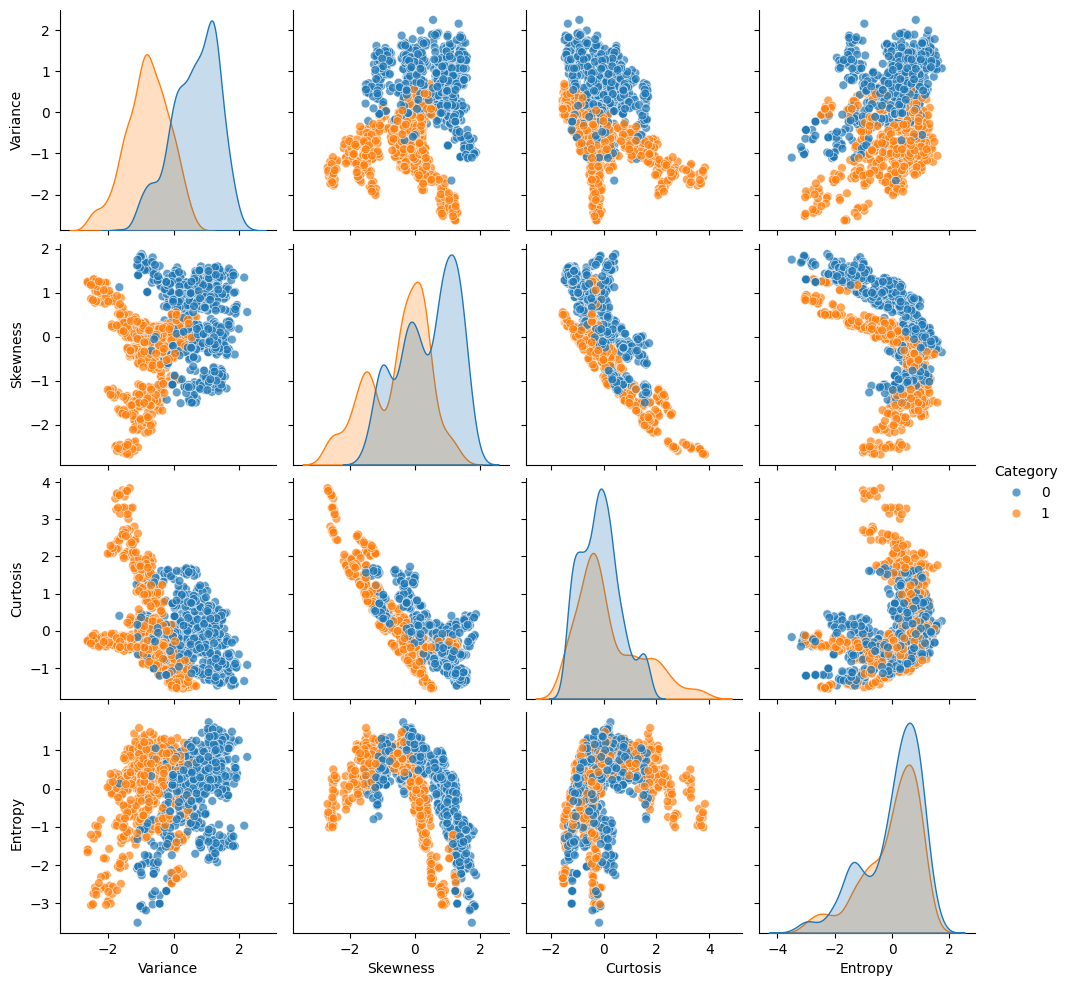

In [25]:
sns.pairplot(df, hue = 'Category', plot_kws={'alpha': 0.7, 's': 40})
plt.show()

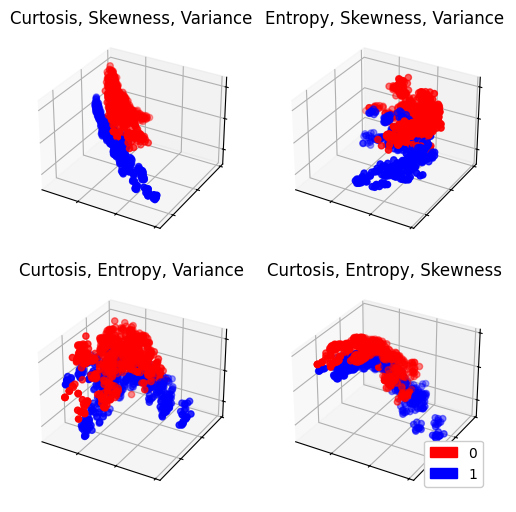

In [26]:
triplets = []
headers = list(df.columns.values)
headers.remove('Category')
triplets = []
for i in range (4):
    for j in range (4):
        for z in range (4):
            if i != j and i != z and j != z:
                to_append = [headers[i], headers[j], headers[z]]
                to_append.sort()
                to_append = tuple(to_append)
                triplets.append(to_append)
triplets = set(triplets)
triplets = [list(trip) for trip in triplets]
df_proof = df[[c for c in df.columns if c in triplets[0]]]

def tridimensional_plot(df, triplets, colors, legend_patches):
    fig = plt.figure(figsize = (6, 6))
    for i, triplet in enumerate(triplets):
        axs = fig.add_subplot(2, 2, i + 1, projection='3d')
        axs.scatter(df[triplet[0]],df[triplet[1]], df[triplet[2]], c = colors, depthshade=True)
        #fig.colorbar(img, location = 'bottom', label = 'State', aspect = 50)
        axs.set_title(f'{triplet[0]}, {triplet[1]}, {triplet[2]}')
        axs.set_yticklabels([])
        axs.set_xticklabels([])  
        axs.set_zticklabels([])
    # Create a legend with a color box
    patches = [mpatches.Patch(color=col, label=lab) for col, lab in legend_patches]
    plt.legend(handles=patches, loc='lower right', framealpha=1, frameon=True)
    plt.show()

colors = ['b' if s == 1 else 'r' for s in df['Category']]
tridimensional_plot(df, triplets, colors, [('r', 0), ('b', 1)])

### 2. Unsupervised Learning

Use PCA and plot the two first components colouring according with the class. Are the classes linearly separable in this projection? What happens when I applied k-means with two classes in this space? And if I use all the coordinates? Try also t-SNE for projection and DBSCAN for the clustering and comment on the results.

In [27]:
from sklearn.decomposition import PCA

nc = 2 # number of components considered

data = np.array(df)
pca_2d = PCA(n_components=nc)
data_pca_2d = pca_2d.fit_transform(data)

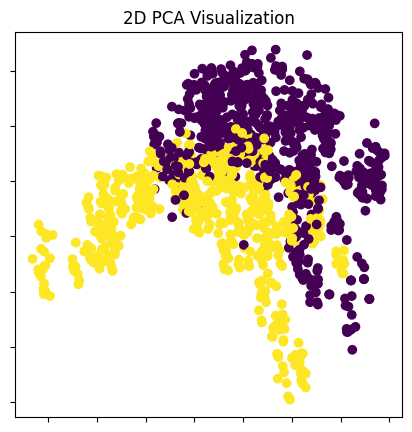

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(data_pca_2d[:, 0], data_pca_2d[:, 1], c=data[:, 4])
ax.set_title('2D PCA Visualization')
ax.set_yticklabels([])
ax.set_xticklabels([]) 

plt.show()

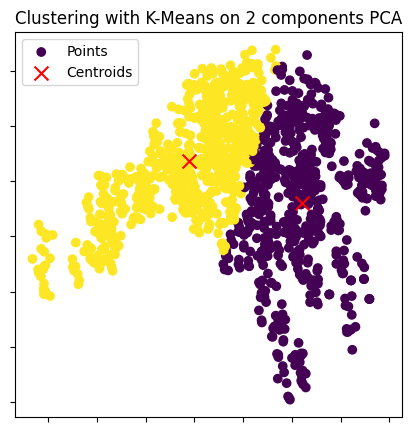

0.5692419825072886


In [ ]:
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from scipy.stats import mode

def kmeans_accuracy(predictions, ground_truth):
    c = 0
    for p, g in zip(predictions, ground_truth):
        c = c + (int(p) == int(g))
    return max(1 - c/len(predictions), c/len(predictions)) # since kmeans does not really classify something as 1 o 0 

kmeans_2d = KMeans(n_clusters=2)
kmeans_2d.fit(data_pca_2d)
labels_2d = kmeans_2d.labels_
centroids_2d = kmeans_2d.cluster_centers_
accuracy_2d = kmeans_accuracy(labels_2d, data[:, 4])
fig, axs = plt.subplots(figsize = (5, 5))
axs.scatter(data_pca_2d[:, 0], data_pca_2d[:, 1], c=labels_2d, label='Points')
axs.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', marker='x', s=100, label='Centroids')
axs.legend()
axs.set_yticklabels([])
axs.set_xticklabels([])  
plt.title("Clustering with K-Means on 2 components PCA")
plt.show()
print(accuracy_2d)

In [30]:
nc = 3 # number of components considered

data = np.array(df)
pca_3d = PCA(n_components=nc)
data_pca_3d = pca_3d.fit_transform(data)

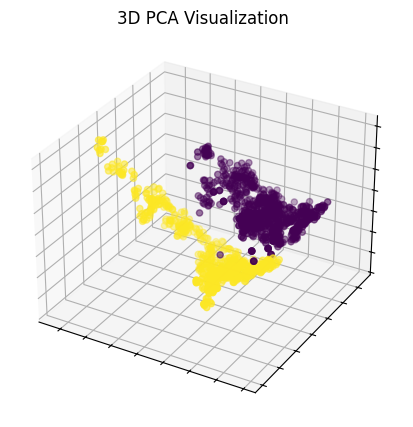

In [31]:
fig = plt.figure(figsize = (5, 5))

axs = fig.add_subplot(111, projection='3d')
axs.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2] , c = data[:, 4], depthshade=True)
axs.set_title('3D PCA Visualization')
axs.set_yticklabels([])
axs.set_xticklabels([])  
axs.set_zticklabels([])

plt.show()

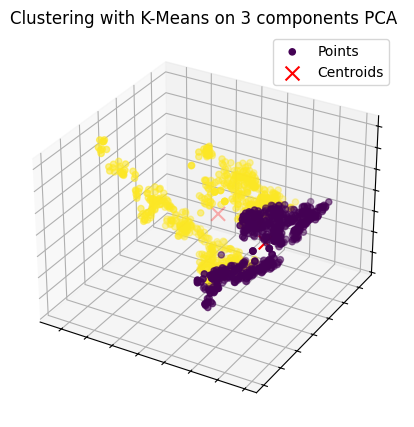

0.5692419825072886


In [32]:
kmeans_3d = KMeans(n_clusters=2)
kmeans_3d.fit(data_pca_3d)
labels_3d = kmeans_3d.labels_
centroids_3d = kmeans_3d.cluster_centers_
accuracy_3d = kmeans_accuracy(labels_3d, data[:, 4])
fig = plt.figure(figsize = (5, 5))
axs = fig.add_subplot(111, projection='3d')
axs.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2],c=labels_3d, label='Points')
axs.scatter(centroids_3d[:, 0], centroids_3d[:, 1], c='red', marker='x', s=100, label='Centroids')
axs.legend()
axs.set_yticklabels([])
axs.set_xticklabels([])  
axs.set_zticklabels([])
plt.title("Clustering with K-Means on 3 components PCA")
plt.show()
print(accuracy_2d)

### 3. Supervised Learning

Generate a subset of the data of 372 elements that would be saved as test set. With the rest of the data generate the following models: Logistic Regression, Decision tree (use the ID3 algorithm), Naive Bayesian and k-NN. 

Investigate the effect of regularization (when possible) and use cross validation for setting the hyper-parameters when needed. 

Compare the performances in terms of accuracy, precision, recall and F1-score on the test set. Comment these results at the light of those obtained from the Unsupervised Learning analysis. Could you propose a way to improve these results?     
